In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Value:
    def __init__(self,data,_children=(), _op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self._backward=lambda: None
        self.grad=0
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        out= Value(self.data+other.data,(self,other),'+')
        def backward():
            self.grad=1*out.grad
            other.grad=1*out.grad
        out._backward=backward
        return out
    def __mul__(self,other):
        out= Value(self.data*other.data,(self,other),'*')
        def backward():
            self.grad=other.data*out.grad
            other.grad=self.data*out.grad
        out._backward=backward
        return out
    def tanh(self):
        t=(math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out=Value(t,(self,),'tanh')
        def backward():
            self.grad=(1-(t**2))*out.grad
        out._backward=backward
        return out

In [5]:
a=Value(3.0,label='a')
b=Value(-4.0,label='b')
c=Value(5.0,label='c')
e=a*b;e.label='e'
d=e+c;d.label='d'
f=Value(2.0,label='f')
L=d*f;L.label='L'

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

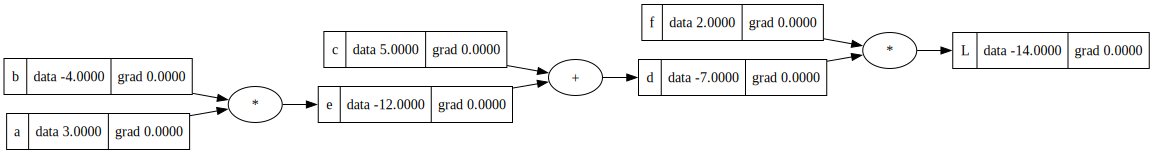

In [7]:
draw_dot(L)